In [1]:
# import dependencies 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts 
from scipy.stats import linregress
import json
import requests

In [2]:
# Load data 
confirmed_xl = 'Resources/tx_confirmed.xlsx'
fatalities_xl = 'Resources/tx_fatalities.xlsx'
county_popn_csv = 'Resources/Population Estimates by County.csv'

# APIs - documentation in resources folder
hospital_cap_url = 'https://opendata.arcgis.com/datasets/1044bb19da8d4dbfb6a96eb1b4ebf629_0.geojson'
nursing_homes_url = 'https://data.cms.gov/resource/s2uc-8wxp.json'# requires login and maybe sodapy ?
deaths_county_race = 'https://data.cdc.gov/api/views/k8wy-p9cg'
excess_death_comparisons = 'https://data.cdc.gov/api/views/m74n-4hbs'
tx_65_url = 'https://data.texas.gov/resource/qjby-4sji.json?'

# Save in dataframe 
confirmed_tx = pd.read_excel(confirmed_xl)
fatalities_tx = pd.read_excel(fatalities_xl)
county_popn = pd.read_csv(county_popn_csv)

In [3]:
# Drop null rows 
confirmed_tx = confirmed_tx.drop([254, 255])

# View data
confirmed_tx

,County,New Cases 03-04-2020,New Cases 03-05-2020,New Cases 03-06-2020,New Cases 03-09-2020,New Cases 03-10-2020,New Cases 03-11-2020,New Cases 03-12-2020,New Cases 03-13-2020,New Cases 03-15-2020,...,New Cases 01-25-2021,New Cases 01-26-2021,New Cases 01-27-2021,New Cases 01-28-2021,New Cases 01-29-2021,New Cases 01-30-2021,New Cases 01-31-2021,New Cases 02-01-2021,New Cases 02-02-2021,New Cases 02-03-2021
0,Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,8.0,1.0,32.0,6.0,-2.0,12.0,0.0,93.0,10.0
1,Andrews,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,19.0,0.0,0.0,0.0,6.0,0.0
2,Angelina,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,112.0,0.0
3,Aransas,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,7.0,5.0,12.0,16.0,4.0,0.0,19.0,4.0
4,Archer,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,Wood,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,85.0,10.0,29.0,0.0,9.0,0.0,0.0,39.0
250,Yoakum,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0
251,Young,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,12.0,6.0,6.0,8.0,6.0,0.0,0.0,20.0,5.0
252,Zapata,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,25.0,1.0,3.0,18.0,3.0,17.0,0.0,21.0,6.0


In [4]:
# Clean up: Delete last row (avoid totaling the total count) / null values & running total columns
fatalities_tx = fatalities_tx[['County Name','Fatalities 02-02-2021']].drop([254,255])

# View data (* data is a running total not additional fatalities per day)
fatalities_tx

,County Name,Fatalities 02-02-2021
0,ANDERSON,91
1,ANDREWS,44
2,ANGELINA,225
3,ARANSAS,31
4,ARCHER,11
...,...,...
249,WOOD,98
250,YOAKUM,25
251,YOUNG,37
252,ZAPATA,23


In [5]:
# Get total for each county 
confirmed_tx['Total Confirmed'] = confirmed_tx.sum(axis=1)

# Select only county and total columns 
confirmed_tx = confirmed_tx[['County', 'Total Confirmed']]

# View 
confirmed_tx

,County,Total Confirmed
0,Anderson,4766.0
1,Andrews,1655.0
2,Angelina,4398.0
3,Aransas,637.0
4,Archer,536.0
...,...,...
249,Wood,1731.0
250,Yoakum,849.0
251,Young,1559.0
252,Zapata,1342.0


In [6]:
# Match indices to merge 
confirmed_tx = pd.DataFrame(confirmed_tx) # Avoid deprecation warning 
fatalities_tx = pd.DataFrame(fatalities_tx) 

# Reformat to match columns 
confirmed_tx['County'] = confirmed_tx['County'].str.title()
fatalities_tx['County Name'] = fatalities_tx['County Name'].str.title()
fatalities_tx = fatalities_tx.rename(columns={'County Name': 'County'})

# Merge dataframes
summary_cases = pd.merge(confirmed_tx, fatalities_tx, on='County')
summary_cases.head()


,County,Total Confirmed,Fatalities 02-02-2021
0,Anderson,4766.0,91
1,Andrews,1655.0,44
2,Angelina,4398.0,225
3,Aransas,637.0,31
4,Archer,536.0,11


In [7]:
## Summary table: add death rate and proportion 65+

# Calculate death rate 
total_cases = summary_cases['Total Confirmed']
total_fatalities = summary_cases['Fatalities 02-02-2021']
summary_cases['% Fatal'] = total_fatalities / total_cases * 100

# Add 65+ population 
county_list = summary_cases['County']

# Reformat county data: remove ', TX' and reformat to titlecase 


# Create empty lists 
county_names = []

# Loop through county list and get 65+ population and county population 
#for county in county_list:
    

summary_cases

,County,Total Confirmed,Fatalities 02-02-2021,% Fatal
0,Anderson,4766.0,91,1.909358
1,Andrews,1655.0,44,2.658610
2,Angelina,4398.0,225,5.115962
3,Aransas,637.0,31,4.866562
4,Archer,536.0,11,2.052239
...,...,...,...,...
248,Wood,1731.0,98,5.661467
249,Yoakum,849.0,25,2.944641
250,Young,1559.0,37,2.373316
251,Zapata,1342.0,23,1.713860


In [8]:
# Print counties with highest fatality rate 
highest_fatality = summary_cases.sort_values('% Fatal', ascending=False, ignore_index=True)
highest_fatality = highest_fatality.head(10)

# View dataframe
highest_fatality


,County,Total Confirmed,Fatalities 02-02-2021,% Fatal
0,Motley,33.0,7,21.212121
1,Sabine,167.0,34,20.359281
2,Kenedy,11.0,2,18.181818
3,Borden,6.0,1,16.666667
4,Stonewall,41.0,6,14.634146
5,Upton,48.0,7,14.583333
6,Foard,50.0,7,14.000000
7,Haskell,149.0,20,13.422819
8,Throckmorton,38.0,5,13.157895
9,Crockett,133.0,15,11.278195


In [9]:
summary_cases['% 65+'] =''
summary_cases

,County,Total Confirmed,Fatalities 02-02-2021,% Fatal,% 65+
0,Anderson,4766.0,91,1.909358,
1,Andrews,1655.0,44,2.658610,
2,Angelina,4398.0,225,5.115962,
3,Aransas,637.0,31,4.866562,
4,Archer,536.0,11,2.052239,
...,...,...,...,...,...
248,Wood,1731.0,98,5.661467,
249,Yoakum,849.0,25,2.944641,
250,Young,1559.0,37,2.373316,
251,Zapata,1342.0,23,1.713860,


In [10]:
# Fix county names (API is case sensitive)
summary_cases = summary_cases.replace({'Mcculloch': 'McCulloch',
                                       'Mclennan': 'McLennan',
                                       'Mcmullen': 'McMullen'})

In [11]:
tx_65_url = 'https://data.texas.gov/resource/qjby-4sji.json?'
#counter = 0
county_list = []
county_sixty_five = []
missing_info = []

for i, row in summary_cases.iterrows():
    
    county = row[0]
    
    query_url = tx_65_url + 'county=' + county
    response = requests.get(query_url).json()
        
    try: 
        over_65 = response[0]['_65_and_older_of_population']
        summary_cases.loc[i, '% 65+'] = over_65
    
        county_name = response[0]['county']
        county_list.append(county_name)
    except (KeyError, IndexError):
        print(f'Missing information for {county}')
        pass
    
    #counter +=1
    #if counter > 5:
        #break
    
#print(json.dumps(response, sort_keys=True, indent=4))
summary_cases

,County,Total Confirmed,Fatalities 02-02-2021,% Fatal,% 65+
0,Anderson,4766.0,91,1.909358,15.100
1,Andrews,1655.0,44,2.658610,9.900
2,Angelina,4398.0,225,5.115962,16.100
3,Aransas,637.0,31,4.866562,27.400
4,Archer,536.0,11,2.052239,20.400
...,...,...,...,...,...
248,Wood,1731.0,98,5.661467,27.600
249,Yoakum,849.0,25,2.944641,13.200
250,Young,1559.0,37,2.373316,21.900
251,Zapata,1342.0,23,1.713860,13.100


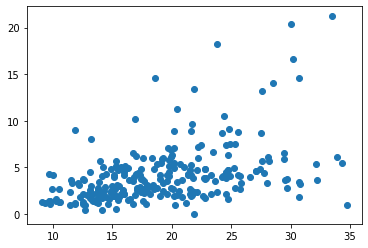

In [37]:
## Build scatterplot

# Get x and y values
x_pc_65 = summary_cases['% 65+']
y_pc_fatality = summary_cases['% Fatal']

# Convert to numeric 
x_pc_65 = pd.to_numeric(x_pc_65)
y_pc_fatality = pd.to_numeric(y_pc_fatality)

# Add to scatterplot
plt.scatter(x_pc_65, y_pc_fatality)
plt.show()

# Add linear regression 